In [ ]:
!rm -rf '/content/sample_data'

# Подготовка среды

## install/update/import/clone

In [ ]:
# Создаем папку для репозитория
!mkdir object_foto_dataset
%cd object_foto_dataset

# Инициализируем пустой репозиторий
!git init

# Добавляем удаленный репозиторий
!git remote add origin https://github.com/torpedonosec80/object_foto_dataset.git

# Включаем sparse checkout
!git config core.sparseCheckout true

# Указываем путь к нужной директории (models_selection/analitic)
!echo "boxes_dataset" >> .git/info/sparse-checkout

# Загружаем только указанную директорию
!git pull origin main  # или master, если используется другая ветка

%cd '/content'

fatal: destination path 'object_foto_dataset' already exists and is not an empty directory.


In [ ]:
!pip install -U torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 127.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8

In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 21.2 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import os
from datetime import datetime
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
import cv2
import xml.etree.ElementTree as ET

## config

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
CLASSES = {
    0: 'background',
    1: 'shta-9m',
    2: 'shta-ps',
    3: 'shta-7m',
    4: 'e2-6u',
    5: 'shta-9',
    6: 'shta-3',
    7: 'sv-5'
}
CLASS_NAME_TO_ID = {v: k for k, v in CLASSES.items()}
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 8
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
PRINT_FREQ = 20

# Path to data
DATA_DIR = "/content/object_foto_dataset/boxes_dataset"

# Transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Inference configuration
MODEL_PATH = 'content/saved_models/best_model.pth'  # Path to the best model
THRESHOLD = 0.5
INFERENCE_DIR = DATA_DIR

## datasets

In [ ]:
import os
import cv2
import numpy as np
import torch
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader, Subset

class CustomDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        self.images = [f for f in os.listdir(img_dir)
                      if f.endswith(('.jpeg', '.jpg', '.JPG', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        ann_path = os.path.join(self.ann_dir, os.path.splitext(img_name)[0] + '.xml')

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        boxes = []
        labels = []

        tree = ET.parse(ann_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name not in CLASS_NAME_TO_ID:
                # Optionally handle unknown classes or skip
                continue
            label = CLASS_NAME_TO_ID[class_name]
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels}

        if self.transforms:
            image = self.transforms(image)

        return image, target, img_name

# Class for inference (only images without annotations)
class InferenceDataset(Dataset):
    def __init__(self, img_dir, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        self.images = sorted([
            f for f in os.listdir(img_dir)
            if f.endswith(('.jpeg', '.jpg', '.JPG', '.png'))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms:
            image = self.transforms(image)

        return image, img_name

def collate_fn(batch):
    return tuple(zip(*batch))

## evaluate

In [ ]:
import torch
import torchmetrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
from torchvision.ops import box_iou
import os


def calculate_map(model, data_loader, device):
    """
    Calculates Mean Average Precision (mAP) using torchmetrics.

    Args:
        model: The PyTorch model to evaluate.
        data_loader: DataLoader for the evaluation dataset.
        device: The device (CPU or GPU) to evaluate on.

    Returns:
        dict: Dictionary containing mAP metrics.
    """
    model.eval()
    # Use standard parameters for compatibility, potentially adjust max_detection_threshold if warnings persist
    metric = torchmetrics.detection.MeanAveragePrecision(
        iou_thresholds=[0.5, 0.75],
        class_metrics=True # Keep class_metrics for detailed analysis later if needed
    )

    with torch.no_grad():
        for batch in data_loader:
            if batch is None:
                continue

            images, targets, names = batch
            if not images or len(images) == 0:
                continue

            images = [img.to(device) for img in images]
            outputs = model(images)

            preds = []
            for output in outputs:
                preds.append({
                    'boxes': output['boxes'].cpu(),
                    'scores': output['scores'].cpu(),
                    'labels': output['labels'].cpu()
                })

            gt = []
            for target in targets:
                gt.append({
                    'boxes': target['boxes'].cpu(),
                    'labels': target['labels'].cpu()
                })

            # Ensure targets have the same keys as preds, even if empty
            # This is a potential source of errors if the metric expects certain keys
            # Let's check if the metric handles empty boxes/labels gracefully or if we need to add checks
            # Based on torchmetrics documentation, it should handle empty lists/tensors.
            # The previous error was likely not directly from this part.

            metric.update(preds, gt)

    # Compute metrics only if updates occurred
    try:
        computed_metrics = metric.compute()
        return computed_metrics
    except RuntimeError as e:
         print(f"Error computing metrics: {e}. This might happen if no detections or ground truths were processed.")
         # Return default values if computation fails (e.g., no data processed)
         return {
            'map': torch.tensor(0.0),
            'map_50': torch.tensor(0.0),
            'map_75': torch.tensor(0.0),
            # Add other expected keys with default values if needed
         }


def calculate_f1_per_class(model, data_loader, device, iou_threshold=0.5, conf_threshold=0.5):
    """
    Calculates F1-Score, Precision, and Recall per class.

    Args:
        model: The PyTorch model to evaluate.
        data_loader: DataLoader for the evaluation dataset.
        device: The device (CPU or GPU) to evaluate on.
        iou_threshold (float): IoU threshold for determining true positives.
        conf_threshold (float): Confidence threshold for filtering predictions.

    Returns:
        tuple: (dict of class metrics, dict of summary metrics)
    """
    model.eval()

    class_stats = {}
    for class_id in CLASSES.keys():
        if class_id == 0:
            continue
        class_stats[class_id] = {
            'true_positives': 0,
            'false_positives': 0,
            'false_negatives': 0
        }

    global_tp = 0
    global_fp = 0
    global_fn = 0

    with torch.no_grad():
        for images_list, targets_list, img_names in data_loader:
            if images_list is None or len(images_list) == 0:
                continue

            images = [img.to(device) for img in images_list]
            outputs = model(images)

            for i, (output, target) in enumerate(zip(outputs, targets_list)):
                keep = output['scores'] > conf_threshold
                pred_boxes = output['boxes'][keep]
                pred_labels = output['labels'][keep]
                # pred_scores = output['scores'][keep] # Not used in F1 calculation logic

                gt_boxes = target['boxes'].to(device)
                gt_labels = target['labels'].to(device)

                for class_id in class_stats.keys():
                    class_mask = pred_labels == class_id
                    pred_class_boxes = pred_boxes[class_mask]

                    gt_class_mask = gt_labels == class_id
                    gt_class_boxes = gt_boxes[gt_class_mask]

                    if len(pred_class_boxes) > 0:
                        if len(gt_class_boxes) > 0:
                            iou_matrix = box_iou(pred_class_boxes, gt_class_boxes)

                            matched_gt = set()
                            for pred_idx in range(len(pred_class_boxes)):
                                max_iou, gt_idx = iou_matrix[pred_idx].max(0)

                                if max_iou >= iou_threshold and gt_idx not in matched_gt:
                                    class_stats[class_id]['true_positives'] += 1
                                    global_tp += 1
                                    matched_gt.add(gt_idx)
                                else:
                                    class_stats[class_id]['false_positives'] += 1
                                    global_fp += 1

                            unmatched_gt = len(gt_class_boxes) - len(matched_gt)
                            class_stats[class_id]['false_negatives'] += unmatched_gt
                            global_fn += unmatched_gt
                        else:
                            class_stats[class_id]['false_positives'] += len(pred_class_boxes)
                            global_fp += len(pred_class_boxes)
                    else:
                        if len(gt_class_boxes) > 0:
                            class_stats[class_id]['false_negatives'] += len(gt_class_boxes)
                            global_fn += len(gt_class_boxes)

    class_metrics = {}
    macro_f1 = 0
    macro_precision = 0
    macro_recall = 0
    total_support = 0
    total_weighted_f1 = 0
    total_weighted_precision = 0
    total_weighted_recall = 0

    for class_id, stats in class_stats.items():
        tp = stats['true_positives']
        fp = stats['false_positives']
        fn = stats['false_negatives']

        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        support = tp + fn

        class_metrics[class_id] = {
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'support': support
        }

        macro_f1 += f1
        macro_precision += precision
        macro_recall += recall

        total_support += support
        total_weighted_f1 += f1 * support
        total_weighted_precision += precision * support
        total_weighted_recall += recall * support

    num_classes_with_support = len([s for s in class_stats.values() if s['true_positives'] + s['false_negatives'] > 0])
    macro_f1 /= num_classes_with_support if num_classes_with_support > 0 else 1
    macro_precision /= num_classes_with_support if num_classes_with_support > 0 else 1
    macro_recall /= num_classes_with_support if num_classes_with_support > 0 else 1


    weighted_f1 = total_weighted_f1 / (total_support + 1e-10)
    weighted_precision = total_weighted_precision / (total_support + 1e-10)
    weighted_recall = total_weighted_recall / (total_support + 1e-10)

    micro_precision = global_tp / (global_tp + global_fp + 1e-10)
    micro_recall = global_tp / (global_tp + global_fn + 1e-10)
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall + 1e-10)

    summary_metrics = {
        'micro': {
            'f1': micro_f1,
            'precision': micro_precision,
            'recall': micro_recall,
            'support': global_tp + global_fn
        },
        'macro': {
            'f1': macro_f1,
            'precision': macro_precision,
            'recall': macro_recall
        },
        'weighted': {
            'f1': weighted_f1,
            'precision': weighted_precision,
            'recall': weighted_recall
        },
        'total_tp': global_tp,
        'total_fp': global_fp,
        'total_fn': global_fn
    }

    return class_metrics, summary_metrics

def visualize_metrics(class_metrics, summary_metrics, classes_dict, save_dir="results"):
    """
    Визуализация метрик F1-Score, Precision и Recall

    Параметры:
    class_metrics (dict): Метрики по классам из calculate_f1_per_class
    summary_metrics (dict): Сводные метрики из calculate_f1_per_class
    classes_dict (dict): Словарь соответствия ID классов и их имен
    save_dir (str): Директория для сохранения графиков
    """
    # Создаем директорию для сохранения, если её нет
    os.makedirs(save_dir, exist_ok=True)

    # Создаем DataFrame для отчета по классам
    class_data = []
    # Handle "unknown" class if it exists and has 0 support
    filtered_class_metrics = {k: v for k, v in class_metrics.items() if v['support'] > 0 or classes_dict[k] != 'unknown'}

    for class_id, metrics in filtered_class_metrics.items():
        class_name = classes_dict[class_id]
        class_data.append({
            'Class': class_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'Support': metrics['support']
        })


    df_class_report = pd.DataFrame(class_data)

    # Ensure the DataFrame is not empty before plotting
    if df_class_report.empty:
        print("No classes with support > 0 found for visualization.")
        return {}


    # График F1-Score по классам
    plt.figure(figsize=(12, 6))
    plt.bar(df_class_report['Class'], df_class_report['F1-Score'], color='skyblue')
    plt.axhline(y=summary_metrics['macro']['f1'], color='r', linestyle='--',
                label=f'Macro F1-Score: {summary_metrics["macro"]["f1"]:.4f}')
    plt.title('F1-Score по классам')
    plt.xlabel('Класс')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    f1_by_class_path = os.path.join(save_dir, 'f1_by_class.png')
    plt.savefig(f1_by_class_path)
    plt.show()
    plt.close()

    # Тепловая карта метрик
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_class_report[['Precision', 'Recall', 'F1-Score']],
                annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=['Precision', 'Recall', 'F1-Score'],
                yticklabels=df_class_report['Class'])
    plt.title('Метрики по классам')
    plt.tight_layout()
    heatmap_path = os.path.join(save_dir, 'metrics_heatmap.png')
    plt.savefig(heatmap_path)
    plt.show()
    plt.close()

    # График Precision-Recall по классам
    plt.figure(figsize=(10, 8))

    # Определяем динамические границы
    min_precision = df_class_report['Precision'].min()
    min_recall = df_class_report['Recall'].min()
    max_precision = df_class_report['Precision'].max()
    max_recall = df_class_report['Recall'].max()

    # Рассчитываем буфер
    buffer = 0.05
    x_min = max(0.0, min_recall - buffer)
    x_max = min(1.0, max_recall + buffer)
    y_min = max(0.0, min_precision - buffer)
    y_max = min(1.0, max_precision + buffer)

    # Ensure at least a small range to avoid errors
    x_min = min(x_min, x_max - 0.01)
    y_min = min(y_min, y_max - 0.01)


    # Создаем scatter plot
    for _, row in df_class_report.iterrows():
        plt.scatter(row['Recall'], row['Precision'], s=120, edgecolors='black')
        plt.text(
            row['Recall'],
            row['Precision'] + 0.005,
            f"{row['Class']}\nF1={row['F1-Score']:.4f}",
            fontsize=9,
            ha='center',
            va='bottom',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
        )

    # Настройка осей и сетки
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall по классам')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Добавляем диагональ
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.2) # Draw from (0,0) to (1,1)

    # Добавляем изолинии F1-Score
    for f1 in [0.5, 0.7, 0.9]:
        # Generate points for the isoline within the plot limits
        x_iso = np.linspace(x_min, x_max, 100)
        with np.errstate(divide='ignore', invalid='ignore'):
            y_iso = np.where(
                (2 * x_iso - f1) != 0,
                f1 * x_iso / (2 * x_iso - f1),
                np.nan
            )

        # Filter out points outside the plot limits and invalid values
        valid_points = (~np.isnan(y_iso)) & (y_iso >= y_min) & (y_iso <= y_max)

        # Find segments of valid points
        if np.any(valid_points):
            valid_indices = np.where(valid_points)[0]
            # Find contiguous segments by looking for breaks in consecutive indices
            breaks = np.where(np.diff(valid_indices) != 1)[0]
            segments = np.split(valid_indices, breaks + 1)

            for segment_indices in segments:
                if len(segment_indices) > 1: # Need at least 2 points to draw a line
                    plt.plot(x_iso[segment_indices], y_iso[segment_indices], 'r--', alpha=0.3, linewidth=0.8)

            # Add label to the last segment's end point if available
            if segments and len(segments[-1]) > 0:
                last_idx_in_segment = segments[-1][-1]
                plt.text(x_iso[last_idx_in_segment], y_iso[last_idx_in_segment], f"F1={f1}",
                         color='red', fontsize=8, ha='right', va='bottom')


    plt.tight_layout()
    pr_path = os.path.join(save_dir, 'precision_recall.png')
    plt.savefig(pr_path)
    plt.show()
    plt.close()

    # Дополнительный график: сравнение микро, макро и взвешенных метрик
    metrics_types = ['micro', 'macro', 'weighted']
    metric_names = ['f1', 'precision', 'recall']

    plt.figure(figsize=(12, 6))
    bar_width = 0.25
    index = np.arange(len(metrics_types))

    for i, metric in enumerate(metric_names):
        values = [summary_metrics[m_type][metric] for m_type in metrics_types]
        plt.bar(index + i * bar_width, values, bar_width, label=metric.capitalize())

    plt.xlabel('Тип усреднения')
    plt.ylabel('Значение метрики')
    plt.title('Сравнение микро, макро и взвешенных метрик')
    plt.xticks(index + bar_width/2, [t.capitalize() for t in metrics_types])
    plt.ylim(0, 1.05) # Adjusted y-limit
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    summary_path = os.path.join(save_dir, 'summary_metrics.png')
    plt.savefig(summary_path)
    plt.show()
    plt.close()

    # Сохраняем данные в CSV
    csv_path = os.path.join(save_dir, 'metrics_report.csv')
    df_class_report.to_csv(csv_path, index=False)

    # Добавляем сводные метрики в отдельный CSV
    summary_data = []
    for m_type in metrics_types:
        for metric in metric_names:
            summary_data.append({
                'Type': m_type,
                'Metric': metric,
                'Value': summary_metrics[m_type][metric]
            })

    summary_df = pd.DataFrame(summary_data)
    summary_csv_path = os.path.join(save_dir, 'summary_metrics.csv')
    summary_df.to_csv(summary_csv_path, index=False)

    return {
        'f1_by_class': f1_by_class_path,
        'metrics_heatmap': heatmap_path,
        'precision_recall': pr_path,
        'summary_metrics': summary_path,
        'class_report_csv': csv_path,
        'summary_report_csv': summary_csv_path
    }

## inference

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
import os


def run_inference(model, inference_loader, device, confidence_threshold, output_csv_path='detection_results.csv'):
    """
    Runs inference on a dataset and saves the detection results to a CSV file.

    Args:
        model: The PyTorch model to use for inference.
        inference_loader: DataLoader for the inference dataset.
        device: The device (CPU or GPU) to run inference on.
        confidence_threshold (float): The minimum confidence score for a detection to be included.
        output_csv_path (str): The path to save the detection results CSV.

    Returns:
        pandas.DataFrame: DataFrame containing the detection results.
    """
    model.eval()
    results = []

    with torch.no_grad():
        for images, image_names in tqdm(inference_loader, desc="Processing images"):
            # Ensure images is a list of tensors before moving to device
            images = [img.to(device) for img in images]
            predictions = model(images)

            for img_name, pred in zip(image_names, predictions):
                boxes = pred['boxes'].cpu().numpy()
                scores = pred['scores'].cpu().numpy()
                labels = pred['labels'].cpu().numpy()

                for i in range(len(boxes)):
                    if scores[i] > confidence_threshold:
                        results.append({
                            'image_name': img_name,
                            'class_id': labels[i],
                            'class_name': CLASSES.get(labels[i], f'unknown_{labels[i]}'), # Handle potential unknown labels
                            'xmin': boxes[i][0],
                            'ymin': boxes[i][1],
                            'xmax': boxes[i][2],
                            'ymax': boxes[i][3],
                            'confidence': scores[i]
                        })

    df_results = pd.DataFrame(results)

    output_dir = os.path.dirname(output_csv_path)
    if output_dir: # Create directory if output_csv_path includes a directory
        os.makedirs(output_dir, exist_ok=True)

    df_results.to_csv(output_csv_path, index=False)

    print(f"Detection completed! Results saved to {output_csv_path}")
    print(f"Total objects detected: {len(df_results)}")
    # Note: Cannot easily print images processed count here without access to the original dataset length

    return df_results

## models

In [ ]:
import torch
import torchvision
from torchvision.models.detection import SSDLite320_MobileNet_V3_Large_Weights
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead


def get_model(num_classes):
    weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
    model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=weights)
    model = model.to(DEVICE)

    model.backbone.eval()
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, 320, 320).to(DEVICE)
        features = model.backbone(dummy_input)
        in_channels_list = [features[str(i)].shape[1] for i in range(len(features))]

    num_anchors = model.anchor_generator.num_anchors_per_location()

    model.head.classification_head = SSDLiteClassificationHead(
        in_channels=in_channels_list,
        num_anchors=num_anchors,
        num_classes=num_classes,
        norm_layer=torch.nn.BatchNorm2d
    ).to(DEVICE)

    for layer in model.head.classification_head.modules():
        if isinstance(layer, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(layer.weight)

    return model

def load_model_for_inference(model_path, num_classes, device):
    model = get_model(num_classes)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

## train

In [ ]:
import torch
import gc
from copy import deepcopy
import matplotlib.pyplot as plt
import os


def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device, print_freq, saved_models_dir='saved_models'):
    """
    Trains the object detection model.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        optimizer: The optimizer for training.
        scheduler: The learning rate scheduler.
        num_epochs (int): The total number of training epochs.
        device: The device (CPU or GPU) to train on.
        print_freq (int): Frequency of printing training loss.
        saved_models_dir (str): Directory to save model checkpoints.
    """
    os.makedirs(saved_models_dir, exist_ok=True)

    best_map = 0.0
    best_model_weights = None
    train_losses = []
    val_maps = []

    for epoch in range(num_epochs):
        # === Training Phase ===
        model.train()
        epoch_loss = 0.0
        for i, (images, targets, _) in enumerate(train_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()
            if i % print_freq == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {i+1}/{len(train_loader)}, Loss: {losses.item():.4f}')

        epoch_avg_loss = epoch_loss / len(train_loader)
        train_losses.append(epoch_avg_loss)
        print(f'Epoch {epoch+1} Train Loss: {epoch_avg_loss:.4f}')

        # === Validation Phase ===
        # Pass the correct classes dictionary to calculate_map if needed internally
        val_metrics = calculate_map(model, val_loader, device)
        val_map = val_metrics['map'].item()
        val_maps.append(val_map)

        print(f'Epoch {epoch+1} Validation mAP: {val_map:.4f}')
        # Check if 'map_50' and 'map_75' exist in the metrics dictionary
        map_50 = val_metrics.get('map_50', torch.tensor(0.0)).item()
        map_75 = val_metrics.get('map_75', torch.tensor(0.0)).item()
        print(f'Validation metrics: mAP@50={map_50:.4f}, mAP@75={map_75:.4f}')


        # Update scheduler
        scheduler.step(val_map)

        # Free up memory
        torch.cuda.empty_cache()
        gc.collect()

        # === Saving Models ===
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(saved_models_dir, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': epoch_avg_loss,
                'val_map': val_map,
            }, checkpoint_path)
            print(f'Saved checkpoint: {checkpoint_path}')

        if val_map > best_map:
            best_map = val_map
            best_model_weights = deepcopy(model.state_dict())
            best_model_path = os.path.join(saved_models_dir, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_weights,
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': epoch_avg_loss,
                'val_map': val_map,
            }, best_model_path)
            print(f'New best model saved with mAP {best_map:.4f} at {best_model_path}')

    # Save the final model
    final_model_path = os.path.join(saved_models_dir, 'final_model.pth')
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': epoch_avg_loss,
        'val_map': val_map, # Use the val_map from the last epoch
    }, final_model_path)
    print(f'Training complete. Final model saved at {final_model_path}')

    # --- Moved final test and plotting to main or evaluation module ---
    # The training function should primarily handle the training loop and saving.

    return model, train_losses, val_maps, best_model_weights

## visualize

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import pandas as pd
import seaborn as sns


def visualize_predictions(model, dataset, num_samples=5, threshold=0.3, save_dir="prediction_visualizations"):
    """
    Visualizes model predictions on a few sample images from the dataset.

    Args:
        model: The trained PyTorch model.
        dataset: The dataset to sample images from (e.g., validation or test dataset).
        num_samples (int): The number of images to visualize.
        threshold (float): Confidence threshold for displaying predictions.
        save_dir (str): Directory to save the visualization images.
    """
    model.eval()
    # Ensure num_samples does not exceed dataset size
    num_samples = min(num_samples, len(dataset))
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(num_samples, 1, figsize=(12, 6 * num_samples))

    # Handle case with only one subplot
    if num_samples == 1:
        axs = [axs]

    os.makedirs(save_dir, exist_ok=True)

    for i, idx in enumerate(indices):
        # Get image, target, and image name from the dataset
        # Note: CustomDataset returns image, target, img_name.
        # InferenceDataset returns image, img_name.
        # We need to handle both possibilities or ensure the dataset provides targets for visualization.
        # Assuming we are visualizing from a dataset *with* targets (like val_dataset or test_dataset)
        try:
             image, target, img_name = dataset[idx]
        except ValueError:
             print(f"Warning: Dataset {type(dataset).__name__} does not provide targets for visualization. Skipping ground truth boxes.")
             image, img_name = dataset[idx]
             target = None # No ground truth available

        ax = axs[i]

        with torch.no_grad():
            # Add batch dimension for inference
            prediction = model([image.to(DEVICE)])[0]

        # Denormalize and permute image for plotting
        img = image.cpu().permute(1, 2, 0).numpy()
        # Assuming standard ImageNet normalization values used in config
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1) # Clip values to [0, 1]

        ax.imshow(img)
        ax.set_title(f"Image: {img_name}", fontsize=12, pad=10)
        ax.axis('off') # Hide axes ticks

        # Plot predictions (Red boxes)
        for score, box, label in zip(prediction['scores'], prediction['boxes'], prediction['labels']):
            if score > threshold:
                box = box.cpu().numpy()
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                        linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                label_name = CLASSES.get(label.item(), f'unknown_{label.item()}') # Handle potential unknown labels
                ax.text(box[0] + 2, box[1] + 10,
                        f'{label_name} {score:.4f}',
                        color='white', fontsize=10,
                        bbox=dict(facecolor='red', alpha=0.8))

        # Plot ground truth (Green dotted boxes)
        if target is not None:
            for box, label in zip(target['boxes'], target['labels']):
                box = box.cpu().numpy()
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                       linewidth=1, edgecolor='g', facecolor='none', linestyle=':')
                ax.add_patch(rect)
                label_name = CLASSES.get(label.item(), f'unknown_{label.item()}') # Handle potential unknown labels
                ax.text(box[2] - 2, box[1] + 10,
                       f'TRUE: {label_name}',
                       color='green', fontsize=8,
                       bbox=dict(facecolor='white', alpha=0.7),
                       horizontalalignment='right')

        # Save individual image visualization
        img_save_path = os.path.join(save_dir, f'prediction_{img_name}')
        # Remove extension from image name for saving
        img_save_path_base, _ = os.path.splitext(img_save_path)
        plt.savefig(f'{img_save_path_base}.png', bbox_inches='tight')


    plt.tight_layout()
    # Optionally save the combined figure
    # plt.savefig(os.path.join(save_dir, 'all_predictions_sample.png'))
    plt.show()
    plt.close(fig) # Close the figure to free memory

def analyze_detection_results(df_results, inference_dataset, save_dir="analysis_results"):
    """
    Analyzes detection results from a DataFrame and generates visualizations and reports.

    Args:
        df_results (pd.DataFrame): DataFrame containing detection results (from run_inference).
        classes_dict (dict): Dictionary mapping class IDs to names.
        save_dir (str): Directory to save analysis results.
    """
    os.makedirs(save_dir, exist_ok=True)

    print("\n--- Analyzing Detection Results ---")

    # 1. Количество обнаружений по классам
    class_counts = df_results['class_name'].value_counts()
    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title('Количество обнаружений по классам')
    plt.xlabel('Класс объекта')
    plt.ylabel('Количество обнаружений')
    plt.xticks(rotation=45)
    plt.tight_layout()
    class_counts_path = os.path.join(save_dir, 'class_counts.png')
    plt.savefig(class_counts_path)
    plt.show()
    plt.close()
    print("\n1. Количество обнаружений по классам:")
    print(class_counts)

    # 2. Средняя уверенность по классам
    confidence_by_class = df_results.groupby('class_name')['confidence'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=confidence_by_class.index, y=confidence_by_class.values, palette='coolwarm')
    plt.title('Средняя уверенность по классам')
    plt.xlabel('Класс объекта')
    plt.ylabel('Средняя уверенность')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    confidence_path = os.path.join(save_dir, 'confidence_by_class.png')
    plt.savefig(confidence_path)
    plt.show()
    plt.close()
    print("\n2. Средняя уверенность по классам:")
    print(confidence_by_class)

    # 3. Распределение размеров объектов
    df_results['width'] = df_results['xmax'] - df_results['xmin']
    df_results['height'] = df_results['ymax'] - df_results['ymin']

    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    sns.histplot(df_results['width'], bins=30, kde=True, color='skyblue')
    plt.title('Распределение ширины объектов')
    plt.xlabel('Ширина (пиксели)')
    plt.ylabel('Количество')

    plt.subplot(2, 2, 2)
    sns.histplot(df_results['height'], bins=30, kde=True, color='salmon')
    plt.title('Распределение высоты объектов')
    plt.xlabel('Высота (пиксели)')
    plt.ylabel('Количество')

    plt.subplot(2, 2, 3)
    sns.scatterplot(data=df_results, x='width', y='height', alpha=0.6)
    plt.title('Соотношение ширина-высота объектов')
    plt.xlabel('Ширина (пиксели)')
    plt.ylabel('Высота (пиксели)')

    plt.subplot(2, 2, 4)
    sns.boxplot(data=df_results, x='class_name', y='width', palette='Set3')
    plt.title('Ширина объектов по классам')
    plt.xlabel('Класс объекта')
    plt.ylabel('Ширина (пиксели)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    size_dist_path = os.path.join(save_dir, 'object_size_distribution.png')
    plt.savefig(size_dist_path)
    plt.show()
    plt.close()

    print("\n3. Статистика размеров объектов:")
    print(df_results[['width', 'height']].describe())

    # 4. Изображения без детекций


    # Получаем список всех обработанных изображений
    all_images = set(inference_dataset.images)

    # Получаем изображения с детекциями
    detected_images = set(df_results['image_name'].unique())

    # Находим изображения без детекций
    no_detection_images = list(all_images - detected_images)

    # Создаем отчет
    no_detection_df = pd.DataFrame({
        'image_name': no_detection_images,
        'detection_status': 'No objects detected'
    })

    # Сохраняем в CSV
    no_detection_path = os.path.join(save_dir, 'images_without_detections.csv')
    no_detection_df.to_csv(no_detection_path, index=False)

    print(f"\n4. Изображения без детекций: {len(no_detection_images)}")
    print(f"Список сохранен в: {no_detection_path}")


    # Save full analysis report
    analysis_report = f"""
    Анализ результатов детекции:
    ------------------------------------
    1. Общее количество обнаруженных объектов: {len(df_results)}
    2. Количество обработанных изображений: {len(all_images)}
    3. Изображений с детекциями: {len(df_results['image_name'].unique())}
    4. Изображений без детекций: {len(no_detection_images)}
    5. Средняя уверенность по всем объектам: {df_results['confidence'].mean():.4f}
    6. Минимальная уверенность: {df_results['confidence'].min():.4f}
    7. Максимальная уверенность: {df_results['confidence'].max():.4f}

    Распределение по классам:
    {class_counts.to_string()}

    Средняя уверенность по классам:
    {confidence_by_class.to_string()}
    """

    report_path = os.path.join(save_dir, 'analysis_report.txt')
    with open(report_path, 'w') as f:
        f.write(analysis_report)

    print(analysis_report)
    print(f"Анализ завершен! Все результаты сохранены в {save_dir}")

    return {
        'class_counts_plot': class_counts_path,
        'confidence_by_class_plot': confidence_path,
        'size_distribution_plot': size_dist_path,
        'analysis_report_txt': report_path,
        'images_without_detections_csv': no_detection_path
    }

# Обучение


## transforms

In [ ]:
full_dataset = CustomDataset(DATA_DIR, DATA_DIR, transform)

indices = list(range(len(full_dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.176, random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

Dataset sizes: Train=654, Val=140, Test=141


## обучение

In [ ]:
model = get_model(NUM_CLASSES)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

os.makedirs('saved_models', exist_ok=True)

best_map = 0.0
best_model_weights = None

train_losses = []
val_maps = []


model, train_losses, val_maps, best_model_weights = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    print_freq=PRINT_FREQ,
    saved_models_dir='saved_models'
)

Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth


100%|██████████| 13.4M/13.4M [00:00<00:00, 59.6MB/s]


Epoch: 1/30, Batch: 1/82, Loss: 19.3309
Epoch: 1/30, Batch: 21/82, Loss: 4.9794
Epoch: 1/30, Batch: 41/82, Loss: 3.6506
Epoch: 1/30, Batch: 61/82, Loss: 3.6592
Epoch: 1/30, Batch: 81/82, Loss: 3.4132
Epoch 1 Train Loss: 5.2210


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Epoch 1 Validation mAP: 0.5435
Validation metrics: mAP@50=0.5890, mAP@75=0.4980
New best model saved with mAP 0.5435 at saved_models/best_model.pth
Epoch: 2/30, Batch: 1/82, Loss: 2.8925
Epoch: 2/30, Batch: 21/82, Loss: 2.5371
Epoch: 2/30, Batch: 41/82, Loss: 2.3244
Epoch: 2/30, Batch: 61/82, Loss: 2.1762
Epoch: 2/30, Batch: 81/82, Loss: 2.5159
Epoch 2 Train Loss: 2.5143
Epoch 2 Validation mAP: 0.7497
Validation metrics: mAP@50=0.7811, mAP@75=0.7184
New best model saved with mAP 0.7497 at saved_models/best_model.pth
Epoch: 3/30, Batch: 1/82, Loss: 1.8470
Epoch: 3/30, Batch: 21/82, Loss: 1.6388
Epoch: 3/30, Batch: 41/82, Loss: 1.3278
Epoch: 3/30, Batch: 61/82, Loss: 2.2612
Epoch: 3/30, Batch: 81/82, Loss: 1.9929
Epoch 3 Train Loss: 1.8039
Epoch 3 Validation mAP: 0.8068
Validation metrics: mAP@50=0.8208, mAP@75=0.7929
New best model saved with mAP 0.8068 at saved_models/best_model.pth
Epoch: 4/30, Batch: 1/82, Loss: 1.2376
Epoch: 4/30, Batch: 21/82, Loss: 1.4645
Epoch: 4/30, Batch: 41/82

время обучения на 30 эпохах составляет 30-40 минут

## оценка тест

In [ ]:
test_metrics = calculate_map(model, test_loader, DEVICE)
test_map = test_metrics['map'].item()
print(f'\n=== Final Test Results ===')
print(f'Test mAP: {test_map:.4f}')
print(f'Test mAP@50: {test_metrics.get("map_50", torch.tensor(0.0)).item():.4f}')
print(f'Test mAP@75: {test_metrics.get("map_75", torch.tensor(0.0)).item():.4f}')
print()


=== Final Test Results ===
Test mAP: 0.8792
Test mAP@50: 0.9084
Test mAP@75: 0.8501



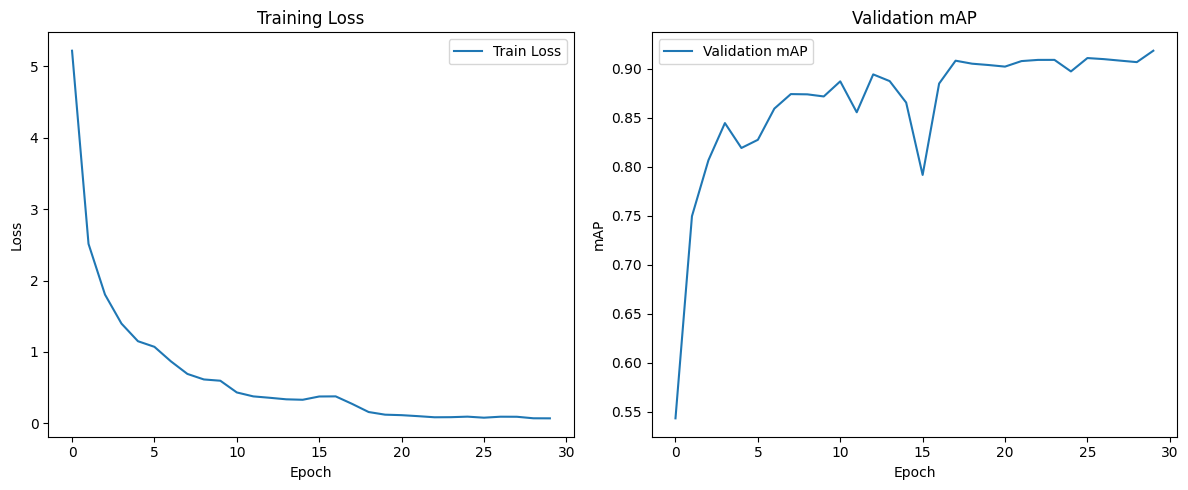

In [ ]:
# Визуализация обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_maps, label='Validation mAP')
plt.title('Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

## image detection

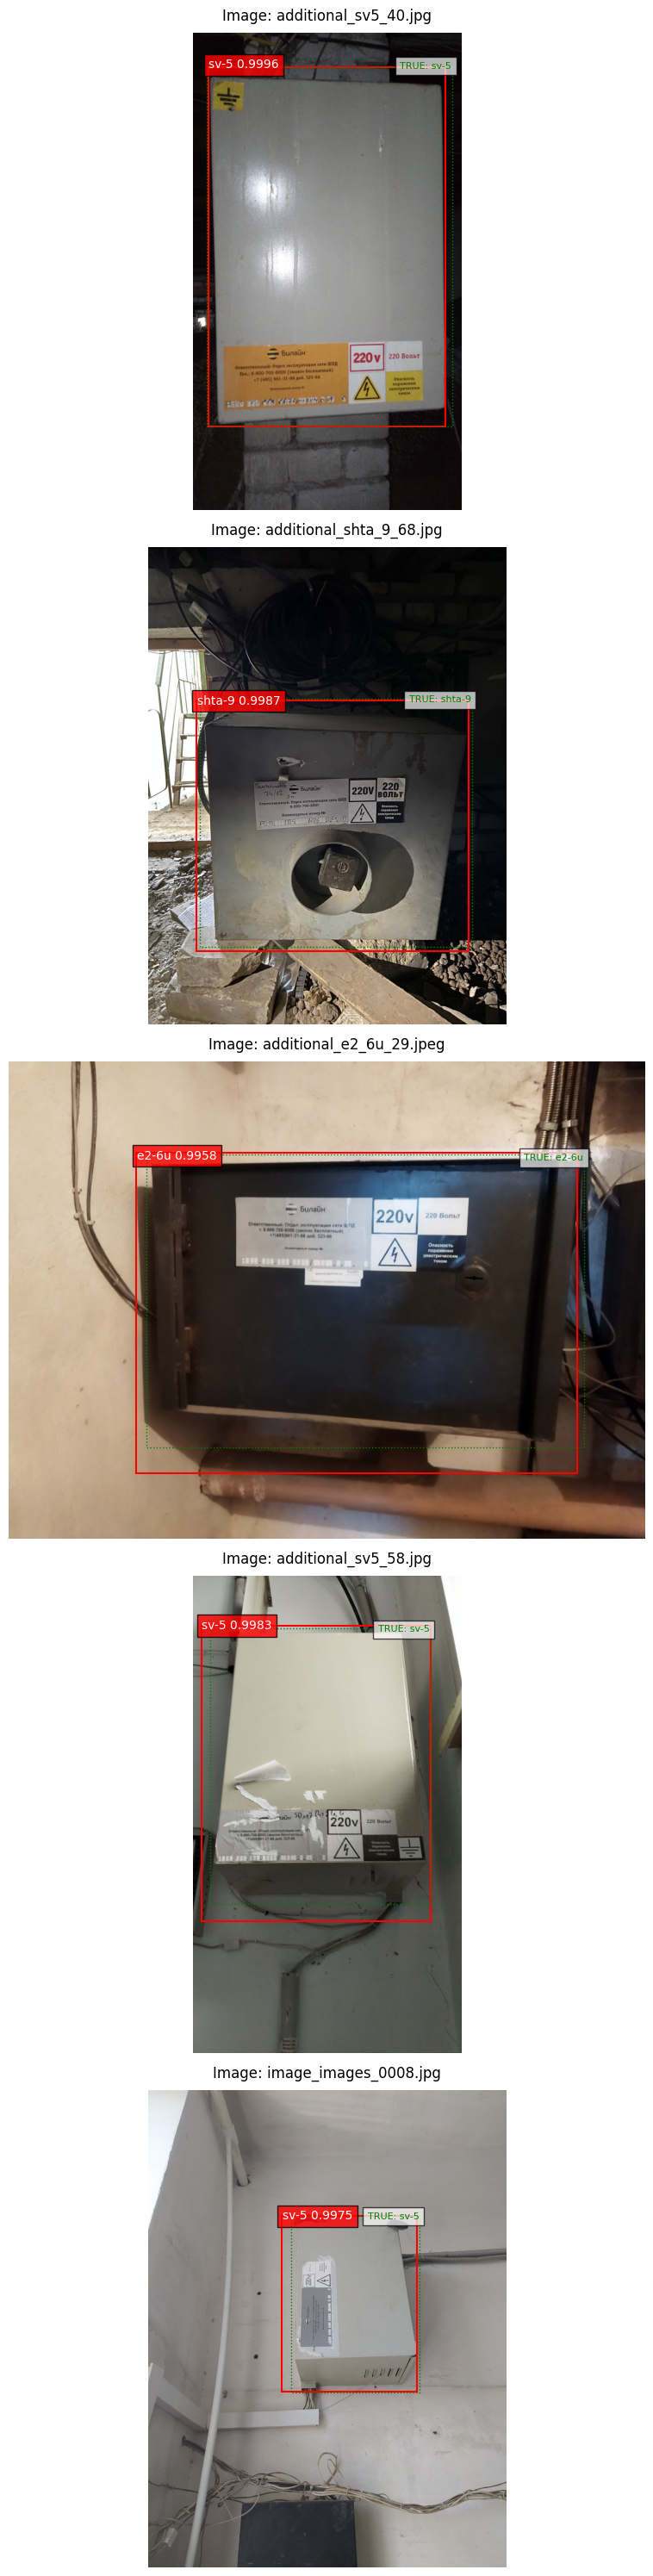

In [ ]:
visualize_predictions(model, val_dataset, num_samples=5, threshold=0.9)

## detection to df

In [ ]:
inference_dataset = InferenceDataset(
    img_dir=INFERENCE_DIR,
    transforms=transform
)

inference_loader = DataLoader(
    inference_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

model = load_model_for_inference(MODEL_PATH, NUM_CLASSES, DEVICE)

detection_results_path = '/content/object_foto_dataset/models_selection/ssd320/detection_results'

print(f"Images to process: {len(inference_dataset)}")

df_results = run_inference(
    model=model,
    inference_loader=inference_loader,
    device=DEVICE,
    confidence_threshold=THRESHOLD,
    output_csv_path=os.path.join(detection_results_path, 'detection_results.csv')
)



Images to process: 935


Processing images: 100%|██████████| 935/935 [01:23<00:00, 11.17it/s]

Detection completed! Results saved to /content/object_foto_dataset/models_selection/ssd320/detection_results/detection_results.csv
Total objects detected: 1072


/content/object_foto_dataset/models_selection/ssd320/visualize.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')



--- Analyzing Detection Results ---


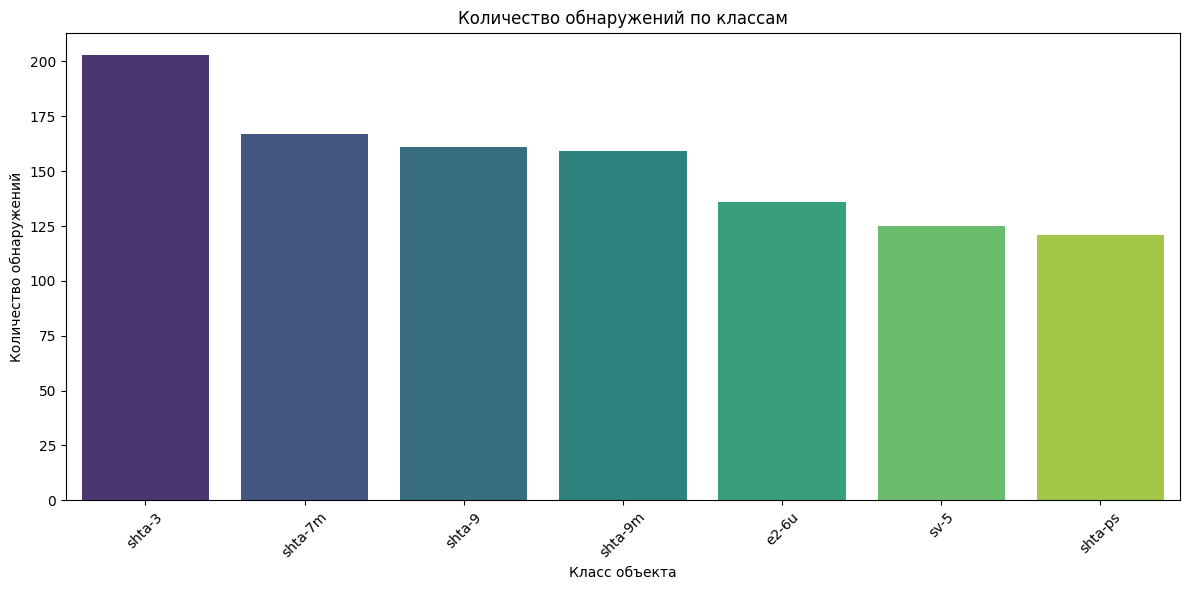


1. Количество обнаружений по классам:
class_name
shta-3     203
shta-7m    167
shta-9     161
shta-9m    159
e2-6u      136
sv-5       125
shta-ps    121
Name: count, dtype: int64


/content/object_foto_dataset/models_selection/ssd320/visualize.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=confidence_by_class.index, y=confidence_by_class.values, palette='coolwarm')


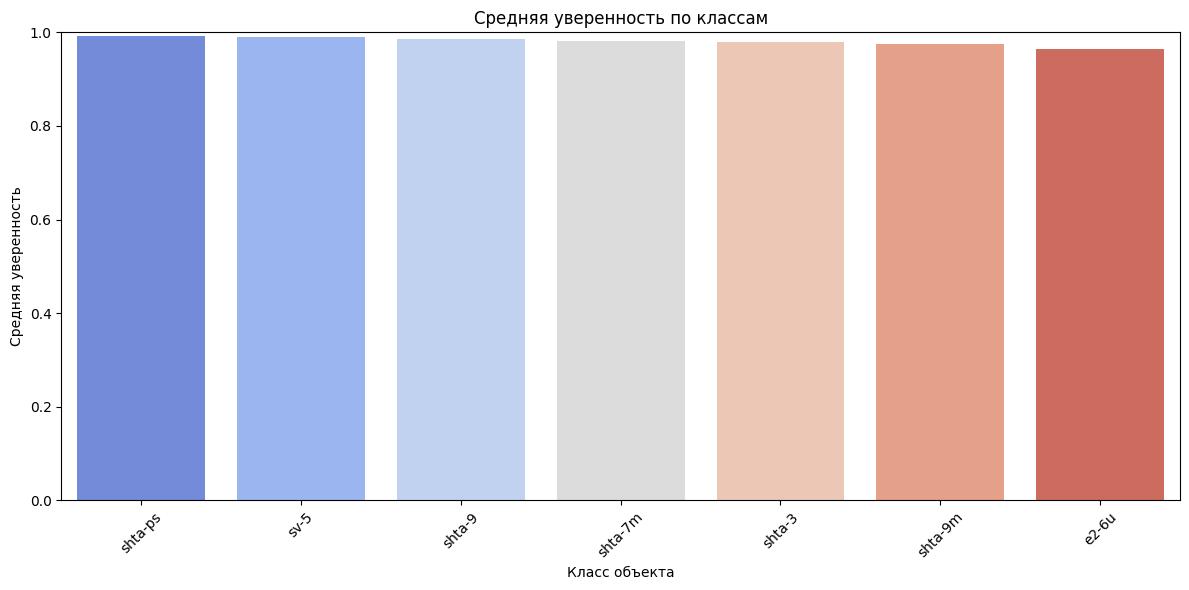


2. Средняя уверенность по классам:
class_name
shta-ps    0.992413
sv-5       0.990662
shta-9     0.985922
shta-7m    0.980430
shta-3     0.978668
shta-9m    0.976024
e2-6u      0.964605
Name: confidence, dtype: float32


/content/object_foto_dataset/models_selection/ssd320/visualize.py:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x='class_name', y='width', palette='Set3')


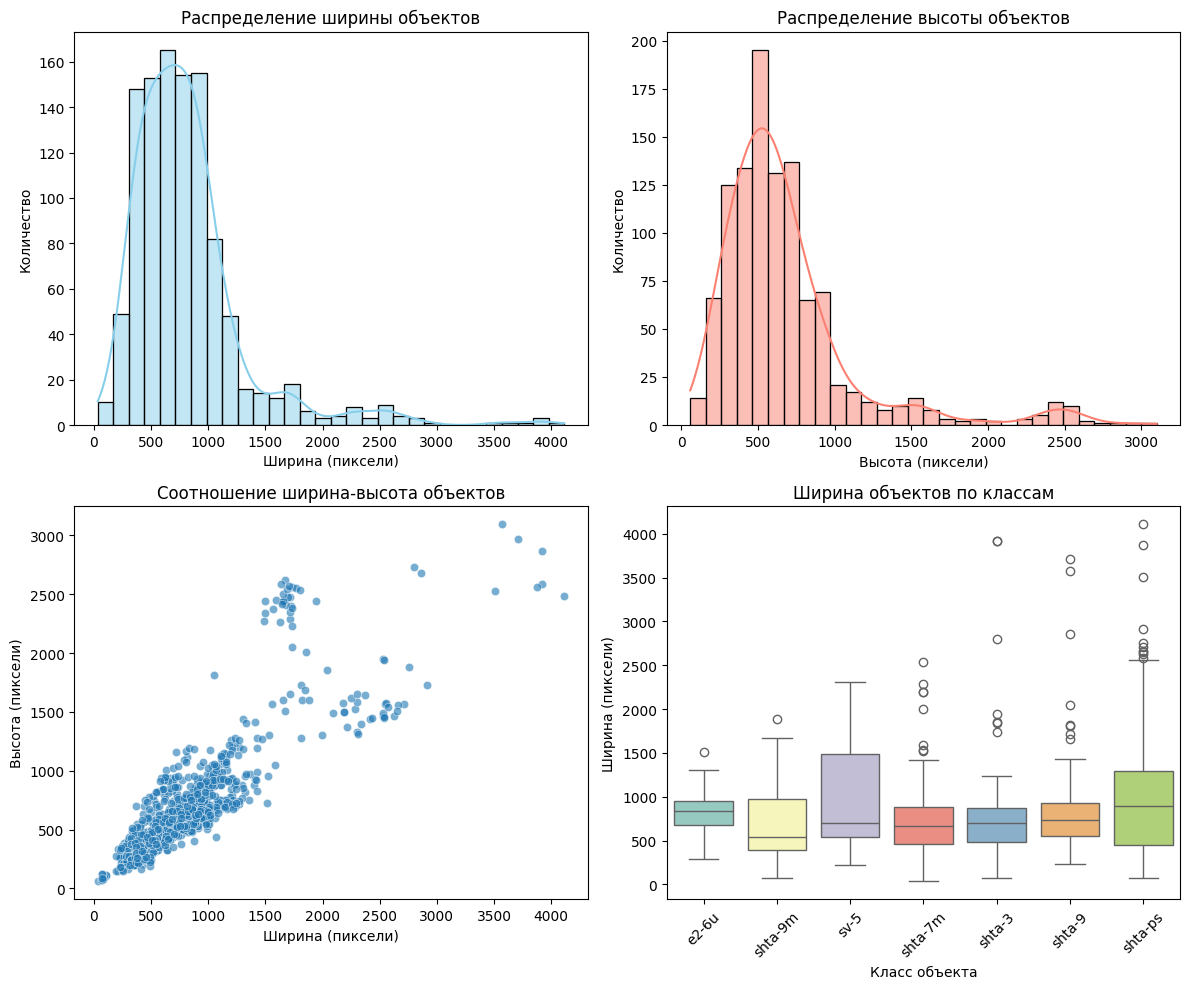


3. Статистика размеров объектов:
             width       height
count  1072.000000  1072.000000
mean    814.771362   679.704285
std     507.173340   461.268799
min      33.161598    59.386322
25%     493.058235   416.163277
50%     722.642731   567.689117
75%     955.227264   770.861176
max    4113.872559  3099.159668

4. Изображения без детекций: 7
Список сохранен в: /content/object_foto_dataset/models_selection/ssd320/detection_results_analysis/images_without_detections.csv

    Анализ результатов детекции:
    ------------------------------------
    1. Общее количество обнаруженных объектов: 1072
    2. Количество обработанных изображений: 935
    3. Изображений с детекциями: 928
    4. Изображений без детекций: 7
    5. Средняя уверенность по всем объектам: 0.9808
    6. Минимальная уверенность: 0.5006
    7. Максимальная уверенность: 1.0000

    Распределение по классам:
    class_name
shta-3     203
shta-7m    167
shta-9     161
shta-9m    159
e2-6u      136
sv-5       125
sht

{'class_counts_plot': '/content/object_foto_dataset/models_selection/ssd320/detection_results_analysis/class_counts.png',
 'confidence_by_class_plot': '/content/object_foto_dataset/models_selection/ssd320/detection_results_analysis/confidence_by_class.png',
 'size_distribution_plot': '/content/object_foto_dataset/models_selection/ssd320/detection_results_analysis/object_size_distribution.png',
 'analysis_report_txt': '/content/object_foto_dataset/models_selection/ssd320/detection_results_analysis/analysis_report.txt',
 'images_without_detections_csv': '/content/object_foto_dataset/models_selection/ssd320/detection_results_analysis/images_without_detections.csv'}

In [ ]:
detection_results_analysis_path = '/content/object_foto_dataset/models_selection/ssd320/detection_results_analysis'

analyze_detection_results(
    df_results=df_results,
    inference_dataset=inference_dataset,
    save_dir=detection_results_analysis_path
)

## F1 and val metrics

In [ ]:
class_metrics, summary_metrics = calculate_f1_per_class(model, test_loader, DEVICE)

# Print results using the calculated metrics
print("\nДетальные метрики по классам:")
for class_id, metrics in class_metrics.items():
    class_name = CLASSES.get(class_id, f"Unknown_{class_id}")
    print(f"{class_name} (ID: {class_id}):")
    print(f"  F1-Score: {metrics['f1']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  Support: {metrics['support']}")
    print()

print("\nИтоговые метрики по всем классам:")
print(f"Общее количество объектов: {summary_metrics['micro']['support']}")
print(f"True Positives (TP): {summary_metrics['total_tp']}")
print(f"False Positives (FP): {summary_metrics['total_fp']}")
print(f"False Negatives (FN): {summary_metrics['total_fn']}")
print()

print("Микро-усреднение (глобальный подсчет):")
print(f"  F1-Score: {summary_metrics['micro']['f1']:.4f}")
print(f"  Precision: {summary_metrics['micro']['precision']:.4f}")
print(f"  Recall: {summary_metrics['micro']['recall']:.4f}")
print()

print("Макро-усреднение (среднее по классам):")
print(f"  F1-Score: {summary_metrics['macro']['f1']:.4f}")
print(f"  Precision: {summary_metrics['macro']['precision']:.4f}")
print(f"  Recall: {summary_metrics['macro']['recall']:.4f}")
print()

print("Взвешенное усреднение (по количеству объектов):")
print(f"  F1-Score: {summary_metrics['weighted']['f1']:.4f}")
print(f"  Precision: {summary_metrics['weighted']['precision']:.4f}")
print(f"  Recall: {summary_metrics['weighted']['recall']:.4f}")


Детальные метрики по классам:
shta-9m (ID: 1):
  F1-Score: 0.7600
  Precision: 0.6552
  Recall: 0.9048
  Support: 21

shta-ps (ID: 2):
  F1-Score: 0.9000
  Precision: 0.9474
  Recall: 0.8571
  Support: 21

shta-7m (ID: 3):
  F1-Score: 0.8000
  Precision: 0.8000
  Recall: 0.8000
  Support: 20

e2-6u (ID: 4):
  F1-Score: 0.7925
  Precision: 0.6774
  Recall: 0.9545
  Support: 22

shta-9 (ID: 5):
  F1-Score: 0.8627
  Precision: 0.8462
  Recall: 0.8800
  Support: 25

shta-3 (ID: 6):
  F1-Score: 0.7586
  Precision: 0.6875
  Recall: 0.8462
  Support: 26

sv-5 (ID: 7):
  F1-Score: 0.8444
  Precision: 0.8636
  Recall: 0.8261
  Support: 23


Итоговые метрики по всем классам:
Общее количество объектов: 158
True Positives (TP): 137
False Positives (FP): 42
False Negatives (FN): 21

Микро-усреднение (глобальный подсчет):
  F1-Score: 0.8131
  Precision: 0.7654
  Recall: 0.8671

Макро-усреднение (среднее по классам):
  F1-Score: 0.8169
  Precision: 0.7825
  Recall: 0.8670

Взвешенное усреднение (по 

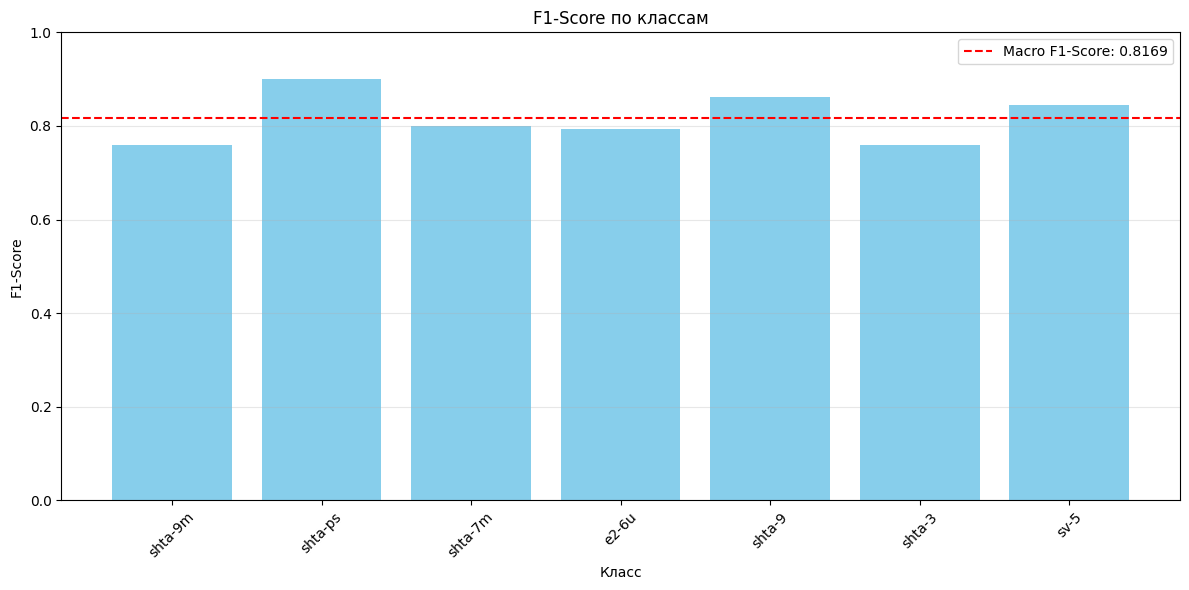

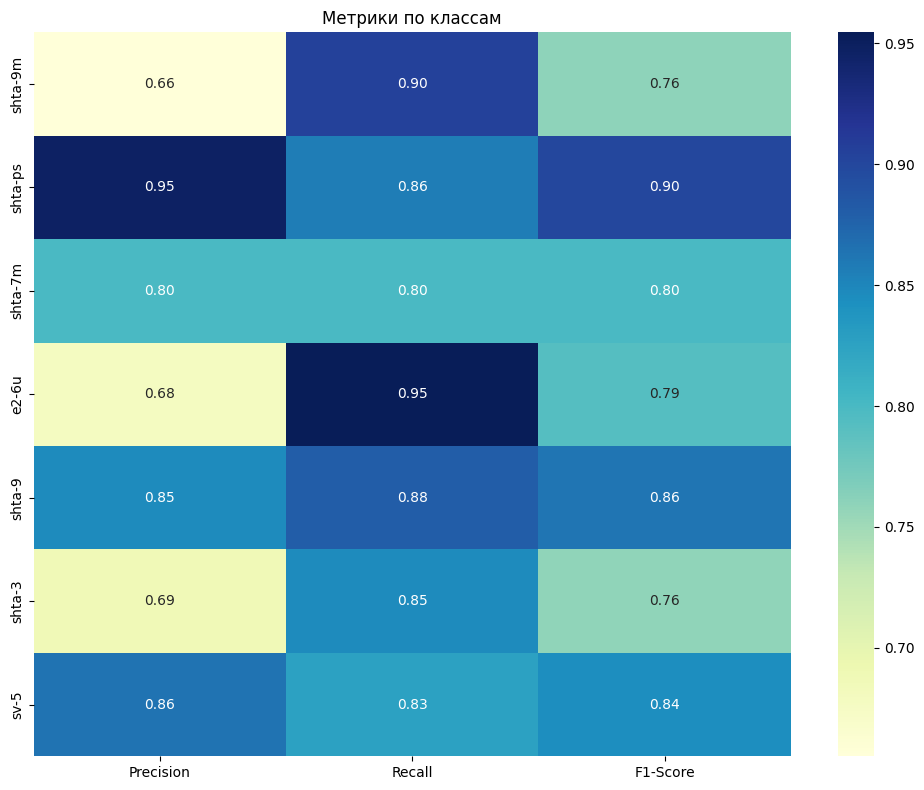

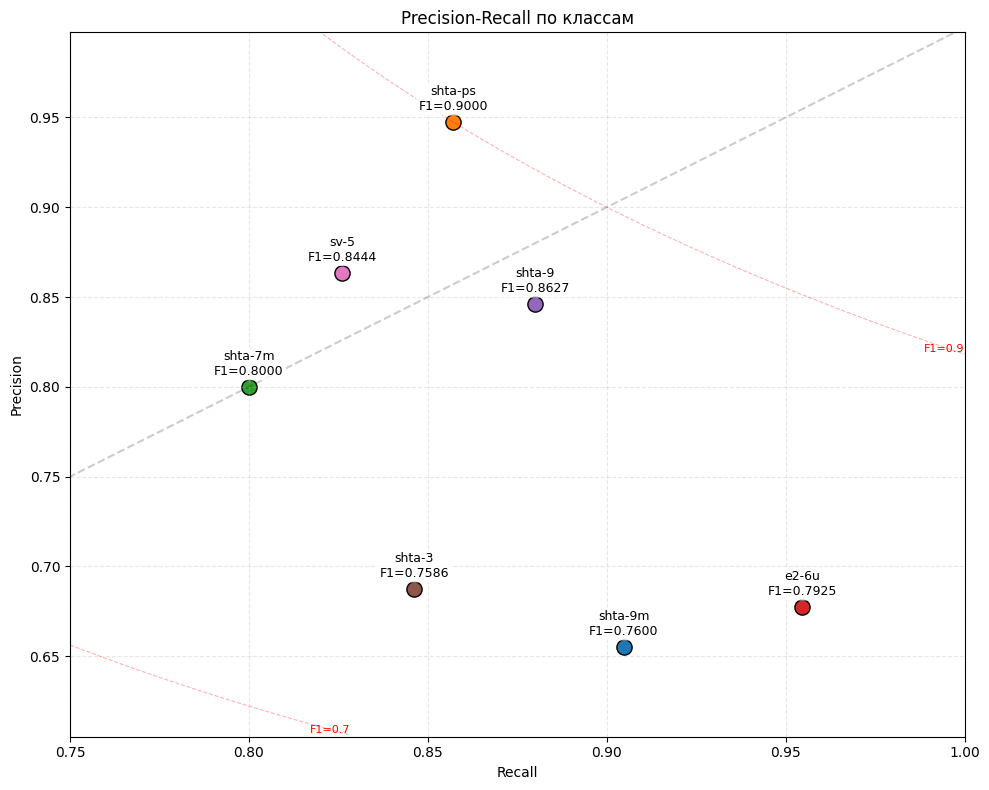

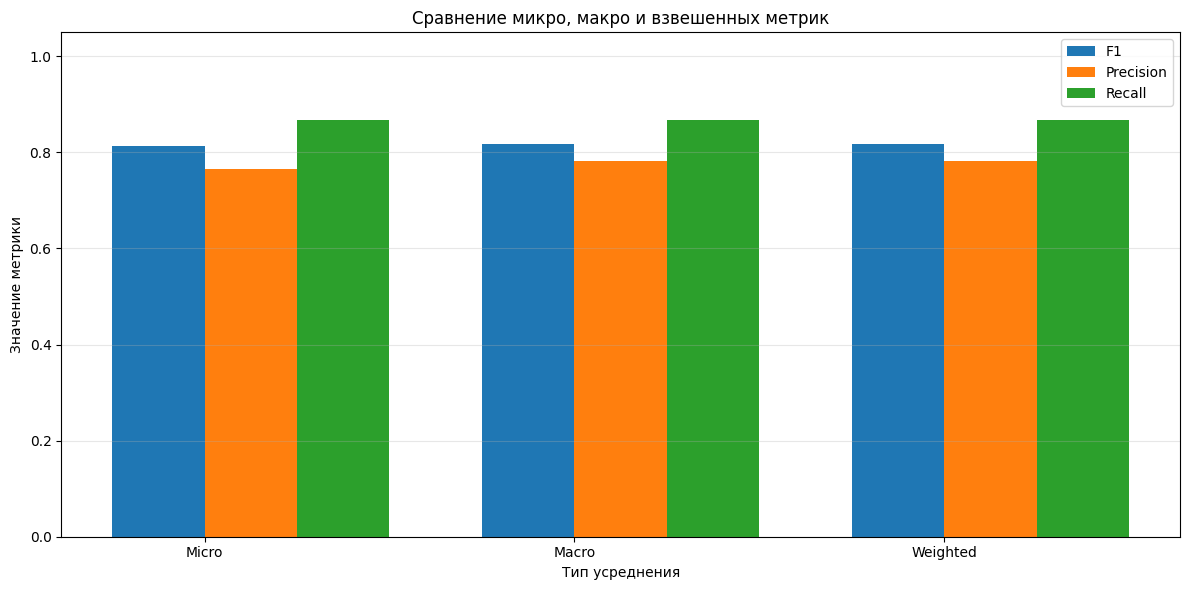


Visualization paths:
{'f1_by_class': '/content/object_foto_dataset/models_selection/ssd320/metrics_results/f1_by_class.png', 'metrics_heatmap': '/content/object_foto_dataset/models_selection/ssd320/metrics_results/metrics_heatmap.png', 'precision_recall': '/content/object_foto_dataset/models_selection/ssd320/metrics_results/precision_recall.png', 'summary_metrics': '/content/object_foto_dataset/models_selection/ssd320/metrics_results/summary_metrics.png', 'class_report_csv': '/content/object_foto_dataset/models_selection/ssd320/metrics_results/metrics_report.csv', 'summary_report_csv': '/content/object_foto_dataset/models_selection/ssd320/metrics_results/summary_metrics.csv'}


In [ ]:
metrics_results_path = '/content/object_foto_dataset/models_selection/ssd320/metrics_results'

visualization_paths = visualize_metrics(
    class_metrics=class_metrics,
    summary_metrics=summary_metrics,
    classes_dict=CLASSES,
    save_dir=metrics_results_path
)

print("\nVisualization paths:")
print(visualization_paths)